# Exploring 2D convolution using NumPy

Inspired by @solomonb's questions in LearnTeachCode LA's #python slack channel.

Solomon was trying to implement 2D convolution on images using kernels/linear operators as a learning exercise.

## First implementation: vanilla Python

Solomon's first implementation was in (almost) plain Python. (Actually, it used a few helpers from numpy, but not in a way that leveraged numpy's performance benefits. I refactored slightly to remove numpy completely.)

In [1]:
# numpy zeros_like workalike for 3-D arrays.
def zeros_like3D(arr):
    return [[[0 for _ in _col] for _col in _row] for _row in arr]

In [2]:
# solomonb's 1st implementation
from typing import List

def mean_blur(arr: List[List[List[int]]]) -> List[List[List[int]]]:
    """
    Perform a mean blur using a 3x3 kernel
    """
    result = zeros_like3D(arr)
    for i in range(len(arr)):
        for j in range(len(arr[0])):
            cells = [arr[y][x]
                       for y in range(max(i-1, 0), min(i+2, len(arr)))
                     for x in range(max(j-1, 0), min(j+2, len(arr[0])))
                    ]
            for k in range(3):
                color = [p[k] for p in cells]
                val = sum(color) / len(color)
                result[i][j][k] = val
    return result

Before diving in, it should be said, this code is pretty nice as is--clean and pretty understandable at first blush.

There are a few things that jump out about this code. The main one, of course, is that the array operation screams for `numpy`. We'll get to that.

On the other hand, let's say we stick with pure Python. A few ideas come to mind.

(Maybe an interesting historical footnote: Solomon's original question was how to get neighboring cells at a given location in a 2D array. The trick was to deal with the borders, which have fewer neighbors, in a clean way. He liked a suggestion I pulled from an implementation of Conway's Game of Life I wrote. That's the list comprehension that sets `cells` in the above function)

In [3]:
# pure Python refactoring

def neighborhood(arr, i, j):
    """Return list of all cells adjacent to cell at i,j (including i,j)"""
    nrows, ncols = [len(arr), len(arr[0])]
    return [arr[x][y]
            for x in range(max(i-1, 0), min(i+2, nrows))
            for y in range(max(j-1, 0), min(j+2, ncols))
           ]


def rgb_average(cells):
    """Return (r,g,b) averaged for each color over all cells"""
    def color_avg(k):
        return sum(c[k] for c in cells) / len(cells)
    return tuple(color_avg(k) for k in [0, 1, 2])


def mean_blur2(arr):
    """
    Perform a mean blur using a 3x3 kernel
    """
    nrows, ncols = [len(arr), len(arr[0])]
    return [[rgb_average(neighborhood(arr, i, j))
             for j in range(ncols)]
            for i in range(nrows)]

Let's test this implementation on an image (using the Pillow package)

In [4]:
from PIL import Image

In [5]:
orig = Image.open("Birds.png")

We are still, on principle, avoiding using numpy, so we have to write our own utility to extract the pixel information from the image into a Python list of lists

In [6]:
def img_to_array(img):
    """Return pixel values of a PIL Image as a Python list of lists"""
    pixels = orig.load()
    w, h = img.size
    return [[pixels[x, y]
             for x in range(w)]
            for y in range(h)]


orig_pixels = img_to_array(orig)

In [7]:
blurred = mean_blur(orig_pixels) # solomon's original blur

In [8]:
blurred2 = mean_blur2(orig_pixels) # jason's refactored blur

We can use matplotlib to look at our results:

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

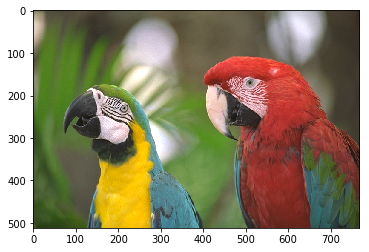

In [10]:
plt.imshow(orig)

To use matplotlib, we have to convert our Python data structures to numpy arrays. So we'll introduce numpy here, but so far we aren't cheating yet: we'll only use it for checking our results.

In [11]:
import numpy as np

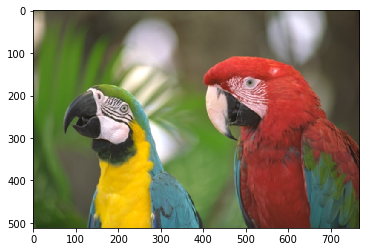

In [12]:
plt.imshow(np.array(blurred, dtype=np.uint8))

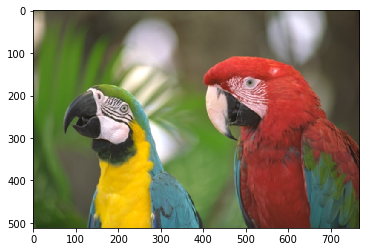

In [13]:
plt.imshow(np.array(blurred2, dtype=np.uint8))

Both work! Let's time them:

In [14]:
%timeit mean_blur(orig_pixels)

3.4 s ± 28 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
%timeit mean_blur2(orig_pixels)

3.84 s ± 30.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The refactored version is slightly slower (<15%). This makes sense because of the extra function calls. Python makes you pay for the clarity you gain from factoring out functions for naming and documentation purposes. In any case, somewhere above 3.4 seconds is the time to beat.

Let's see how we can get numpy to do most of the work we are doing by hand.

# Using NumPy

I then pushed Solomon to use numpy, and after a few iterations, he ended up with this:

In [16]:
def mean_blur_np(arr: np.array) -> np.array:
    """
    Perform a mean blur using a 3x3 kernel
    """
    result = np.zeros_like(arr)
    for i in range(len(arr)):
        for j in range(len(arr[0])):
            cells = arr[max(0, i-1):min(len(arr), i+2),
                          max(0, j-1):min(len(arr[0]), j+2)]
            size = cells.shape[0]*cells.shape[1]
            result[i][j] = np.divide(np.sum(np.sum(cells, axis=0), axis=0), size)    
    return result

Let's time it. Did we gain anything from those `np.divide`s and `np.sum`s?

In [17]:
orig_np = np.array(orig)

In [18]:
%timeit mean_blur_np(orig_np)

5.93 s ± 116 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Oops. It got a lot slower. 65% slower. 

This is pretty surprising. There isn't anything notably different about the algorithm between this first numpy version and the vanilla Python version. It's possible that the numpy version will scale better to much larger images, but it's looking pretty bad for numpy.

Let's play around with mostly stylistic changes that could affect performance:

In [19]:
def mean_blur_np2(arr: np.array) -> np.array:
    """
    Perform a mean blur using a 3x3 kernel
    """
    result = np.empty_like(arr)
    nrows, ncols = arr.shape[:2]
    for i in range(nrows):
        rmin, rmax = [max(0, i-1), min(nrows, i+2)]
        for j in range(ncols):
            cmin, cmax = [max(0, j-1), min(ncols, j+2)]
            cells = arr[rmin:rmax, cmin:cmax]
            size = cells.shape[0] * cells.shape[1]
            result[i,j] = np.sum(cells, axis=(0, 1)) // size  # np.mean is 2 seconds slower!
    return result

In [20]:
%timeit mean_blur_np2(orig_np)

4.12 s ± 79.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


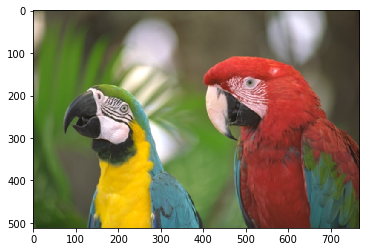

In [21]:
plt.imshow(mean_blur_np2(orig_np))

Alright, so that's much better, but still notably with the worst pure Python version. And it required a lot of tuning and testing to boot. Why does numpy make such a poor showing here?

The numpy game is getting rid of loops. The most costly loops are the ones that iterate through every pixel. We still have those. Their cost appears to dominate the function so much that numpy can't do much to improve performance beyond base Python, and the overhead of numpy is a liability in this scenario.

The real key, then, will be to get rid of those loops.

## NumPy, fully vectorized solution

What keeps the loops around in the above solution? The tricky part is as we process each pixel, we need to capture all of its neighbors. To do that, we need to know the pixel's index so we can choose the right slice of the image to consider. Choosing a moving window like this isn't something that's easy to do with the standard numpy slicing and/or broadcasting rules for indexing.

But we aren't stuck. It takes a lot more cleverness, and more understanding of how the underlying `ndarray` object really works, but we can use `numpy` to select _all_ the windows around _all_ the pixels at the same time. This will allow us to vectorize the whole operation in one go.

What we'll do is create an alternative view of the pixel values in the image. Instead of one (i,j) point giving one RGB value, and (i,j) pont in the new view will instead point to a 2D array of RGB values: namely all the neighboring points in the window around point (i,j).

In [22]:
from numpy.lib.stride_tricks import as_strided

In [23]:
def strided_image(img, kernel_size):
    padw = kernel_size[0] // 2
    padh = kernel_size[1] // 2
    padded = np.pad(img, mode='constant', pad_width=((padw,padw),(padh,padh),(0,0)))
    shape = [*padded.shape[:-1], *kernel_size, padded.shape[-1]]
    strides = [*padded.strides[:-1], *padded.strides]
    shape[0] -= padw * 2 # apparent shape hides pad
    shape[1] -= padh * 2
    return as_strided(padded, shape=shape, strides=strides)

In [24]:
s = strided_image(orig_np, (3,3))

In [25]:
(orig_np.shape, orig_np.strides)

((512, 768, 3), (2304, 3, 1))

In [26]:
(s.shape, s.strides)

((512, 768, 3, 3, 3), (2310, 3, 2310, 3, 1))

Note the two extra dimensions in the strided image `s` that are inserted just before the last dimension. These indicate that each 2-D location of `s` is now a 3x3 array of RGB values. The strides account for these extra dimensions as well as the padding we add to make every location have a valid window of the same size. Otherwise, the borders would need special handling because they have too few neighboring cells compared to the center points.

Now we can build a `mean_blur` function around this strided view:

In [27]:
def mean_blur_full_numpy(arr, kernel_size=(3,3)):
    summed = np.sum(strided_image(arr, kernel_size), axis=(-3, -2))
    
    ncells = kernel_size[0] * kernel_size[1]
    corner_idx = [(0,0,-1,-1), (0,-1,0,-1)]
    summed[1:-1, 1:-1]   //= ncells                            # center pixels
    summed[[0,-1], 1:-1] //= ncells - kernel_size[1]           # top/bottom rows
    summed[1:-1, [0,-1]] //= ncells - kernel_size[0]           # left/right cols
    summed[corner_idx]   //= ncells - np.sum(kernel_size) + 1  # corners
    return summed.astype(np.uint8)

In [28]:
b = mean_blur_full_numpy(orig_np, (3,3))

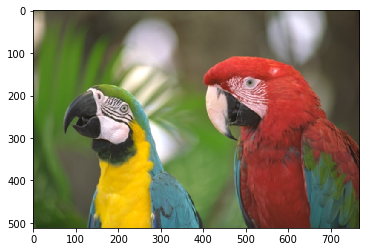

In [29]:
plt.imshow(b)

In [30]:
%timeit mean_blur_full_numpy(orig_np)

313 ms ± 14.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


And we have a >10x speed up from the best performing version to this point (incidentally, the first vanilla Python version).

Notice that we try to do a lot with the strided view all at once. We don't want to store the intermediate results of that array because the memory demands are a much higher than the original array. Hopefully, we can convince numpy to never create an actual instance of that array. By the time we get the array `summed`, we've already collapsed the extra dimensions in our strided view by summing. So `summed` is the same size as the original image.

One awkwardness is the averaging that we do over several lines to different slices of `summed`. There's some neat ideas in there about different forms of indexing into numpy arrays. But it's still a little ugly, and it results from our having to treat every pixel as if it has the same number of neighbors. The pad we add allows us to do that, but we don't want to count pad pixels in the averaging because they aren't "real".


## The real NumPy version

For good measure, let's see how to do it using everything numpy/scipy provides for us already.

In [31]:
from scipy import ndimage

In [32]:
kernel_size = (3,3,1)
kernel = np.zeros(kernel_size)
kernel[:] = 1 / np.prod(kernel_size[:2])
img_scipy = ndimage.convolve(orig_np, kernel, mode='constant')

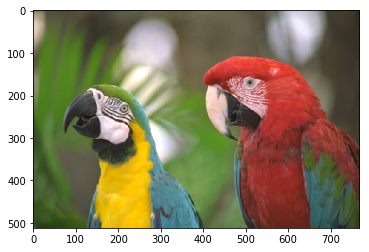

In [33]:
plt.imshow(img_scipy)